# The purpose of this script is to 

In [1]:
import wandb

In [2]:
import pickle
import numpy as np
import random
from datasets import Dataset
import pandas as pd

In [3]:
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification

import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

# use_keras = True
# model_name = 'bert'

train_eval_split = 0.8
number_of_labels = 2

use_keras = False
model_name = 'scibert'

dataset_choice = 'keywords'
#dataset_choice = 'tldr'
#dataset_choice = 'imdb'


model_path = {'bert':'bert-base-cased',
              'scibert': 'allenai/scibert_scivocab_uncased'}

tokenizer = AutoTokenizer.from_pretrained(model_path[model_name])



if use_keras:
    model = TFAutoModelForSequenceClassification.from_pretrained(model_path[model_name], num_labels=number_of_labels)
else:
    model = AutoModelForSequenceClassification.from_pretrained(model_path[model_name],
                                                               num_labels=number_of_labels, 
                                                               attention_probs_dropout_prob=0.5,
                                                               hidden_dropout_prob=0.5)


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [4]:
with open('data/2021_neurips_processed_paper_data.pkl', 'rb') as file:
    paper_data = pickle.load(file)
    
    
paper_by_name_dict = {}
for paper in paper_data:
    if paper['title'] in paper_by_name_dict:
        paper_by_name_dict[paper['title']]['review_2'] = paper
    else:
        paper_by_name_dict[paper['title']] = paper
        
paper_data = list(paper_by_name_dict.values())

In [5]:
abstract_list = []
average_score_list = []


tldr_list = []
tldr_scores = []

keyword_list = []

rating_list = []
keyword_dict = {}

for paper in paper_data:
    ratings = []
    for rating in paper['rating_list']:
        ratings.append(float(rating.split(':')[0]))
    rating_list.append(np.mean(ratings))
print(np.mean(rating_list))


quantile_values = []
quantile_values.append(-1000)
for i in range(number_of_labels-1):
    quantile_values.append(np.quantile(rating_list, (i+1)/number_of_labels))
quantile_values.append(1000)


for paper in paper_data:
    
    ratings = []
    for rating in paper['rating_list']:
        ratings.append(float(rating.split(':')[0]))
    if len(ratings) == 0:
        continue
    
    for j in range(number_of_labels):
        if np.mean(ratings) >= quantile_values[j] and np.mean(ratings) < quantile_values[j+1]:
            average_score_list.append(j)
            break

#     if np.mean(ratings) > np.mean(rating_list):
#         average_score_list.append(1)
#     else:
#         average_score_list.append(0)
        
    keyword_str = ''
    for i, keyword in enumerate(paper['keywords']):
        if keyword not in keyword_dict:
            keyword_dict[keyword] = 0
        keyword_dict[keyword] += 1
        
        if i >= 1:
            keyword_str += ' [SEP] '
        keyword_str += keyword.lower() 
    keyword_list.append(keyword_str)

    #average_score_list.append(np.mean(ratings))
    
    if paper['tldr'] is not None:
        tldr_list.append(paper['tldr'])
        tldr_scores.append(average_score_list[-1])
    
    abstract_list.append(paper['abstract'].lower())
    
    
    

6.339634322744894


In [6]:
np.unique(average_score_list, return_counts=True) 

(array([0, 1]), array([1157, 1312], dtype=int64))

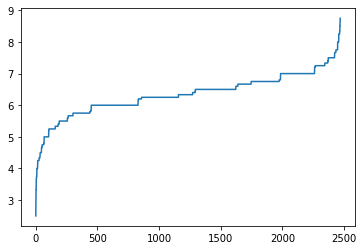

In [7]:
import matplotlib.pyplot as plt
plt.plot(sorted(rating_list))

In [8]:
450+1189+830

2469

In [9]:
len(tldr_list)

1960

In [10]:
quantile_values

[-1000, 6.333333333333333, 1000]

In [11]:
np.median(rating_list)

6.333333333333333

In [12]:
(2+1)/number_of_labels

1.5

In [13]:
number_of_labels

2

In [14]:
np.sum(np.array(rating_list)<6.0)

450

In [15]:
np.sum(np.array(rating_list)<6.333333)

1157

In [16]:
np.sum(np.array(average_score_list)==4)

0

# Test with IMDB dataset

In [17]:
from datasets import load_dataset

raw_datasets = load_dataset("imdb")

Reusing dataset imdb (C:\Users\Chris\.cache\huggingface\datasets\imdb\plain_text\1.0.0\2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

### See https://huggingface.co/docs/datasets/loading.html#pandas-dataframe for more loading options

In [18]:


if dataset_choice == 'imdb':
    small_train_dataset = raw_datasets['train'].shuffle(seed=42).select(range(500)) 
    raw_dataset = small_train_dataset
    max_length = 512
    #     abstract_list = [x.lower() for x in small_train_dataset['text'][:2500]]
#     average_score_list = small_train_dataset['label'][:2500]
    
elif dataset_choice == 'tldr':
    max_length = 60
    abstract_list = [x.lower() for x in tldr_list]
    average_score_list = tldr_scores
    raw_dataset_dict = {'text': abstract_list, 'label':average_score_list}
    raw_dataset = Dataset.from_dict(raw_dataset_dict)
    
elif dataset_choice =='keywords':
    max_length = 50
    abstract_list = keyword_list
    average_score_list = average_score_list
    raw_dataset_dict = {'text': abstract_list, 'label':average_score_list}
    raw_dataset = Dataset.from_dict(raw_dataset_dict)
    
    

In [19]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length",max_length=max_length, truncation=True)

tokenized_datasets = raw_dataset.map(tokenize_function, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

In [20]:
example_text = tokenized_datasets['text'][10]
output = tokenizer.encode(example_text)
print(example_text)
print(tokenizer.convert_ids_to_tokens(output))

graph embedding [SEP] poincare embedding [SEP] hyperbolic space [SEP] negative sampling [SEP] generalization error [SEP] statistical learning theory [SEP] rademacher complexity
['[CLS]', 'graph', 'embedding', '[SEP]', 'poin', '##care', 'embedding', '[SEP]', 'hyperbolic', 'space', '[SEP]', 'negative', 'sampling', '[SEP]', 'generalization', 'error', '[SEP]', 'statistical', 'learning', 'theory', '[SEP]', 'rad', '##ema', '##cher', 'complexity', '[SEP]']


In [21]:
max_length = 0
s = []
for x in tokenized_datasets['input_ids']:
    for j in range(len(x)-1,-1,-1):
        if x[j] != 0:
            s.append(j)
#             if j > max_length:
#                 max_length = j
#                 print(x)
            break

In [22]:
np.mean(s)

14.787363304981774

In [23]:
np.quantile(s,.995)

42.0

In [24]:


split_train_test = tokenized_datasets.shuffle(seed=42).train_test_split(test_size=1-train_eval_split, train_size=train_eval_split)
train_dataset = split_train_test['train']
eval_dataset = split_train_test['test']


# Pytorch

In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments("test_trainer",
                                  num_train_epochs=40,
                                 per_device_train_batch_size=16,
                                per_device_eval_batch_size=16,
                                 evaluation_strategy='epoch',
                                report_to="wandb")

In [26]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [27]:
from transformers import Trainer
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [28]:
%%time
%%wandb
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 1975
  Num Epochs = 40
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2480
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: cnielsen (use `wandb login --relogin` to force relogin)


C:\Users\Chris\anaconda3\envs\phd\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\Chris\anaconda3\envs\phd\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.701301,0.491903
2,No log,0.694260,0.512146
3,No log,0.716916,0.479757
4,No log,0.687251,0.546559
5,No log,0.749012,0.534413
6,No log,0.852335,0.566802
7,No log,1.154054,0.528340
8,No log,1.467501,0.538462
9,0.584000,1.288409,0.562753
10,0.584000,1.650813,0.542510


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 494
  Batch size = 32
C:\Users\Chris\anaconda3\envs\phd\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\Chris\anaconda3\envs\phd\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 494
  Batch size = 32
C:\Users\Chris\anaconda3\envs\phd\lib\site-packages\torch\nn\parallel\_functi

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 494
  Batch size = 32
C:\Users\Chris\anaconda3\envs\phd\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\Chris\anaconda3\envs\phd\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 494
  Batch size = 32
C:\Users\Chris\anaconda3\envs\phd\lib\site-packages\torch\nn\parallel\_functi

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 494
  Batch size = 32
C:\Users\Chris\anaconda3\envs\phd\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\Chris\anaconda3\envs\phd\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 494
  Batch size = 32
C:\Users\Chris\anaconda3\envs\phd\lib\site-packages\torch\nn\parallel\_functi

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 494
  Batch size = 32
C:\Users\Chris\anaconda3\envs\phd\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\Chris\anaconda3\envs\phd\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 494
  Batch size = 32
C:\Users\Chris\anaconda3\envs\phd\lib\site-packages\torch\nn\parallel\_functi

Wall time: 12min 34s


In [ ]:
trainer.evaluate()

# Keras computation

In [13]:
tf_train_dataset = train_dataset.remove_columns(["text"]).with_format("tensorflow")
tf_eval_dataset = eval_dataset.remove_columns(["text"]).with_format("tensorflow")

In [14]:
train_features = {x: tf_train_dataset[x] for x in tokenizer.model_input_names}
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, tf_train_dataset["label"]))
train_tf_dataset = train_tf_dataset.shuffle(len(tf_train_dataset)).batch(8)

eval_features = {x: tf_eval_dataset[x] for x in tokenizer.model_input_names}
eval_tf_dataset = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset["label"]))
eval_tf_dataset = eval_tf_dataset.batch(8)

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

model.fit(train_tf_dataset, validation_data=eval_tf_dataset, epochs=20)

Epoch 1/20
247/247 [==============================] - 45s 142ms/step - loss: 1.0384 - sparse_categorical_accuracy: 0.4846 - val_loss: 1.0246 - val_sparse_categorical_accuracy: 0.4858
Epoch 2/20
247/247 [==============================] - 33s 134ms/step - loss: 1.0364 - sparse_categorical_accuracy: 0.4684 - val_loss: 1.0283 - val_sparse_categorical_accuracy: 0.4858
Epoch 3/20
247/247 [==============================] - 33s 134ms/step - loss: 1.0386 - sparse_categorical_accuracy: 0.4765 - val_loss: 1.0243 - val_sparse_categorical_accuracy: 0.4858
Epoch 4/20
247/247 [==============================] - 33s 134ms/step - loss: 1.0402 - sparse_categorical_accuracy: 0.4603 - val_loss: 1.0459 - val_sparse_categorical_accuracy: 0.4858
Epoch 5/20
247/247 [==============================] - 33s 135ms/step - loss: 1.0410 - sparse_categorical_accuracy: 0.4744 - val_loss: 1.0228 - val_sparse_categorical_accuracy: 0.4858
Epoch 6/20
230/247 [==========================>...] - ETA: 2s - loss: 1.0452 - sparse

KeyboardInterrupt: 

# Interpret Results

### CLS token meaning: https://datascience.stackexchange.com/questions/66207/what-is-purpose-of-the-cls-token-and-why-is-its-encoding-output-important

In [27]:
from transformers_interpret import SequenceClassificationExplainer
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)

In [30]:
eval_dataset

Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
    num_rows: 494
})

In [28]:
train_dataset

Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
    num_rows: 1975
})

In [31]:
keyword_attributions_df = []
keyword_str_df = []

for i in range(len(train_dataset['text'])):
    print(i)
    text = train_dataset['text'][i]
    
    word_attributions = cls_explainer(text)
    
    keyword_str = ''
    attributions = []
    for j in range(len(word_attributions)):
        word = word_attributions[j][0]
        attribution = word_attributions[j][1]
        
        if word == '[CLS]':
            continue
        
        
        if word == '[SEP]':
            keyword_str_df.append(keyword_str)
            keyword_attributions_df.append(np.mean(attributions))
            keyword_str = ''
            attributions = []
        else:
            if '##' == word[:2]:
                keyword_str += word[2:]
            else:
                keyword_str += ' ' + word
            attributions.append(attribution)
            
#     if i > 10:
#         break
            

    
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


C:\Users\Chris\anaconda3\envs\phd\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Chris\anaconda3\envs\phd\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
3

1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974


In [32]:

keyword_attribution_df = pd.DataFrame({'keyword': keyword_str_df,
                                       'attribution': keyword_attributions_df})



In [33]:
keyword_attribution_df

,keyword,attribution
0,deep learning,-0.141026
1,adversarial attacks,0.087903
2,adversarial defences,-0.292095
3,robustness,-0.626162
4,multi - agent reinforcement learning,-0.181489
...,...,...
8254,generalization,-0.295504
8255,hyperparameter optimization,-0.014574
8256,generalization,-0.029383
8257,bilevel optimization,-0.222872


In [47]:
mean_attribution_df = keyword_attribution_df.groupby('keyword').mean()
mean_attribution_df = mean_attribution_df.dropna()

size_df = keyword_attribution_df.groupby('keyword').size()
size_df = size_df.rename('size')

processed_df = pd.concat([size_df,mean_attribution_df],axis=1).reset_index(level=0)

threshold_n = 5
filtered_df = processed_df[processed_df['size'] > threshold_n]

# filtered_df.nlargest(20,'attribution')
filtered_df.nsmallest(20,'attribution')

,keyword,size,attribution
595,complexity,6,-0.547280
1955,invariance,11,-0.546363
3921,stability,7,-0.480536
1546,global convergence,6,-0.456429
1902,information theory,12,-0.439864
4187,theory,16,-0.427655
3599,robustness,44,-0.413738
4374,variance reduction,8,-0.410390
2663,mutual information,6,-0.404581
3470,regret,7,-0.396733


In [43]:
mean_attribution_df.nsmallest(20,'attribution')

,attribution
keyword,
registration,-0.858761
association,-0.815601
dynamics,-0.793292
sensitivity,-0.761046
independence,-0.760467
similarity metrics,-0.671879
gain,-0.663806
binding,-0.661484
goal reaching,-0.632956


In [40]:
mean_attribution_df

,attribution
keyword,
$ c \ mu $ rule,-0.168611
( application ) natural language and text processing,-0.112577
( other ) statistics,-0.376812
1 - bit compessed sensing,-0.155115
2 - alternating capacities,0.005283
...,...
zero - sum games,-0.140324
zero - sum markov game,-0.046056
zero - sum matrix game,-0.082494


In [36]:
keyword_attribution_df.nlargest(10, 'attribution')

,keyword,attribution
4940,transformer,1.000000
6441,transformer,0.944352
1555,fairness,0.783986
5067,transformer,0.778151
5833,fairness,0.769278
4405,transformer,0.742193
4173,peer review,0.701151
1673,drug discovery,0.687367
2764,humans,0.682191
2237,regularization,0.655965


In [40]:
train_dataset['text'][0]

'multi-task learning [SEP] task groupings [SEP] which tasks should train together'

In [ ]:
train_dataset

In [32]:
'ss'.split('##')

['ss']

In [43]:

word_attributions = cls_explainer("I love you, I like you")
print(word_attributions)

[('[CLS]', 0.0), ('i', -0.1260166035078643), ('love', 0.2762164790705415), ('you', 0.621887923546016), (',', 0.29504598098690893), ('i', -0.09620406455332652), ('like', 0.15553210773929782), ('you', 0.6329155499803294), ('[SEP]', 0.0)]


In [31]:
text_example = train_dataset['text'][3]

word_attributions = cls_explainer(text_example)
cls_explainer.visualize()


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.62),LABEL_1,3.46,[CLS] minima ##x problems [SEP] non ##convex - non ##conc ##ave problems [SEP] extra ##gradient method [SEP] acceleration [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.62),LABEL_1,3.46,[CLS] minima ##x problems [SEP] non ##convex - non ##conc ##ave problems [SEP] extra ##gradient method [SEP] acceleration [SEP]


In [ ]:
[SEP]

In [44]:
cls_explainer.predicted_class_index

array(1, dtype=int64)

In [45]:
cls_explainer.predicted_class_name

'LABEL_1'

In [46]:
cls_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.64),LABEL_1,1.76,"[CLS] i love you , i like you [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.64),LABEL_1,1.76,"[CLS] i love you , i like you [SEP]"
